### Coursera IBM Data Science Course Assignment Project
### Capstone Project Battle of Neighborhood 

In [1]:
import numpy as np
import pandas as pd

#### Load csv that contains location info of all train stations (including Mass Rapid Transit(MRT) and Light Rail Transit(LRT)) in Singapore

In [2]:
url = 'https://query.data.world/s/heji2ztgpnwx5j5362iqgspyjioh2u'
df_sgp = pd.read_csv(url)
df_sgp

,OBJECTID,STN_NAME,STN_NO,X,Y,Latitude,Longitude,COLOR
0,12,ADMIRALTY MRT STATION,NS10,24402.1063,46918.1131,1.440585,103.800998,RED
1,16,ALJUNIED MRT STATION,EW9,33518.6049,33190.0020,1.316433,103.882893,GREEN
2,33,ANG MO KIO MRT STATION,NS16,29807.2655,39105.7720,1.369933,103.849553,RED
3,81,BAKAU LRT STATION,SE3,36026.0821,41113.8766,1.388093,103.905418,OTHERS
4,80,BANGKIT LRT STATION,BP9,21248.2460,40220.9693,1.380018,103.772667,OTHERS
...,...,...,...,...,...,...,...,...
182,175,WOODLANDS SOUTH MRT STATION,TE3,23607.8309,45444.7113,1.427260,103.793863,OTHERS
183,146,WOODLEIGH MRT STATION,NE11,32173.3186,35706.3794,1.339190,103.870808,PURPLE
184,6,YEW TEE MRT STATION,NS5,18438.9791,42158.0124,1.397535,103.747431,RED
185,41,YIO CHU KANG MRT STATION,NS15,29294.1283,40413.0820,1.381756,103.844944,RED


### Create a map of Singapore with MRT/LRT station markers superimposed on top.

In [3]:
import json     # library to handle JSON files
import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

In [4]:
!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim     # convert an address into latitude and longitude values

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



In [5]:
!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.5.11
  latest version: 4.7.12

Please update conda by running

    $ conda update -n base -c defaults conda



# All requested packages already installed.



#### Use geopy library to get the latitude and longitude values of Singapore.

In [6]:
address = 'Singapore'

geolocator = Nominatim(user_agent="sg_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

In [7]:
# create map of Singapore country using latitude and longitude values obtained in previous step
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=12)

# add markers of MRT & LRT stations to Singapore map
for lat, lng, stn_name, stn_no in zip(df_sgp['Latitude'], df_sgp['Longitude'], df_sgp['STN_NAME'], df_sgp['STN_NO']):
    label = '{}, {}'.format(stn_name, stn_no)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=2,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore)  

map_singapore

#### Utilizing the Foursquare API to explore the neighborhoods and segment them.

In [8]:
CLIENT_ID = 'M5X1UESNPMFLLUAMYJ1CANYZKLTLB1SYPYK0ONMDQADMBTKO' # your Foursquare ID
CLIENT_SECRET = 'STAGRGUQR5BUENTFKW4WXZIOQXU4KBOYZHF000QLSDTPPKMZ' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

#### Create a new dataframe that combines the Station Name and Station No. to form Station Identifier (STATION_ID) and drop irrelevant columns

In [9]:
df_stnloc = df_sgp[['Latitude', 'Longitude']].copy(deep=True)
df_stnloc['Station ID'] = df_sgp['STN_NAME'] + ' (' + df_sgp['STN_NO'] + ')'

# move Station_ID column to the first column
new_columns = [df_stnloc.columns[-1]] + list(df_stnloc.columns[:-1])
df_stnloc = df_stnloc[new_columns]
df_stnloc.head()

,Station ID,Latitude,Longitude
0,ADMIRALTY MRT STATION (NS10),1.440585,103.800998
1,ALJUNIED MRT STATION (EW9),1.316433,103.882893
2,ANG MO KIO MRT STATION (NS16),1.369933,103.849553
3,BAKAU LRT STATION (SE3),1.388093,103.905418
4,BANGKIT LRT STATION (BP9),1.380018,103.772667


#### Define a function to explore the nearby venues of each train station

In [10]:
LIMIT = 50    # limit of number of venues returned by Foursquare API
RADIUS = 500   # define radius

def getNearbyVenues(station_ids, latitudes, longitudes, radius=RADIUS):
    
    count = 1
    venues_list=[]
    for stn_id, lat, lng in zip(station_ids, latitudes, longitudes):
        print(count, stn_id)
        count = count + 1
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([(
                stn_id,
                lat, 
                lng, 
                v['venue']['name'], 
                v['venue']['location']['lat'], 
                v['venue']['location']['lng'],  
                v['venue']['categories'][0]['name']) for v in results])
            
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [
                  'Station ID', 
                  'Stn Latitude', 
                  'Stn Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [11]:
sgp_venues = getNearbyVenues(station_ids=df_stnloc['Station ID'],
                             latitudes=df_stnloc['Latitude'],
                             longitudes=df_stnloc['Longitude']
                             )

print("***** Completed getting nearby venues info *****")

1 ADMIRALTY MRT STATION (NS10)
2 ALJUNIED MRT STATION (EW9)
3 ANG MO KIO MRT STATION (NS16)
4 BAKAU LRT STATION (SE3)
5 BANGKIT LRT STATION (BP9)
6 BARTLEY MRT STATION (CC12)
7 BAYFRONT MRT STATION (DT16)
8 BAYFRONT MRT STATION (CE1)
9 BEAUTY WORLD MRT STATION (DT5)
10 BEDOK MRT STATION (EW5)
11 BEDOK NORTH MRT STATION (DT29)
12 BEDOK RESERVOIR MRT STATION (DT30)
13 BENCOOLEN MRT STATION (DT21)
14 BENDEMEER MRT STATION (DT23)
15 BISHAN MRT STATION (CC15)
16 BISHAN MRT STATION (NS17)
17 BOON KENG MRT STATION (NE9)
18 BOON LAY MRT STATION (EW27)
19 BOTANIC GARDENS MRT STATION (DT9)
20 BOTANIC GARDENS MRT STATION (CC19)
21 BRADDELL MRT STATION (NS18)
22 BRAS BASAH MRT STATION (CC2)
23 BUANGKOK MRT STATION (NE15)
24 BUGIS MRT STATION (DT14)
25 BUGIS MRT STATION (EW12)
26 BUKIT BATOK MRT STATION (NS2)
27 BUKIT BROWN MRT STATION (CC18)
28 BUKIT GOMBAK MRT STATION (NS3)
29 BUKIT PANJANG LRT STATION (BP6)
30 BUKIT PANJANG MRT STATION (DT1)
31 BUONA VISTA MRT STATION (EW21)
32 BUONA VISTA MRT S

In [12]:
print(sgp_venues.shape)
sgp_venues.head()

(5337, 7)


,Station ID,Stn Latitude,Stn Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,Kampung Admiralty Hawker Centre,1.439939,103.800774,Food Court
1,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,Starbucks,1.439761,103.800659,Coffee Shop
2,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,NTUC Fairprice,1.439955,103.800761,Supermarket
3,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,Saamsudeen,1.439802,103.800750,Halal Restaurant
4,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,NTUC FairPrice,1.437707,103.797636,Supermarket


In [13]:
len(sgp_venues['Station ID'].unique())

187

#### Find out how many venues were returned for each neighborhood

In [14]:
sgp_venues.groupby('Station ID').count()

,Stn Latitude,Stn Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Station ID,,,,,,
ADMIRALTY MRT STATION (NS10),5,5,5,5,5,5
ALJUNIED MRT STATION (EW9),45,45,45,45,45,45
ANG MO KIO MRT STATION (NS16),40,40,40,40,40,40
BAKAU LRT STATION (SE3),12,12,12,12,12,12
BANGKIT LRT STATION (BP9),11,11,11,11,11,11
...,...,...,...,...,...,...
WOODLANDS SOUTH MRT STATION (TE3),6,6,6,6,6,6
WOODLEIGH MRT STATION (NE11),11,11,11,11,11,11
YEW TEE MRT STATION (NS5),9,9,9,9,9,9


In [15]:
sgp_venues.shape

(5337, 7)

#### Find out how many unique categories can be curated from all the returned venues

In [16]:
print('There are {} uniques categories.'.format(len(sgp_venues['Venue Category'].unique())))

There are 308 uniques categories.


### Analyze each MRT/LRT station

In [17]:
# one hot encoding
sgp_onehot = pd.get_dummies(sgp_venues[['Venue Category']], prefix="", prefix_sep="")
print(sgp_onehot.shape)

# add station name column back to dataframe
sgp_onehot['Station ID'] = sgp_venues['Station ID'] 

# move neighborhood column to the first column
reorder_columns = [sgp_onehot.columns[-1]] + list(sgp_onehot.columns[:-1])
sgp_onehot = sgp_onehot[reorder_columns]

sgp_onehot.head(20)


(5337, 308)


,Station ID,ATM,Accessories Store,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,...,Warehouse Store,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ADMIRALTY MRT STATION (NS10),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ADMIRALTY MRT STATION (NS10),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ADMIRALTY MRT STATION (NS10),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ADMIRALTY MRT STATION (NS10),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ADMIRALTY MRT STATION (NS10),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,ALJUNIED MRT STATION (EW9),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,ALJUNIED MRT STATION (EW9),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,ALJUNIED MRT STATION (EW9),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,ALJUNIED MRT STATION (EW9),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,ALJUNIED MRT STATION (EW9),0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [18]:
sgp_onehot.shape

(5337, 309)

#### Group rows by station id and taking the mean of the frequency of occurrence for each venue category

In [19]:
sgp_onehot_grouped = sgp_onehot.groupby('Station ID').mean().reset_index()
sgp_onehot_grouped

,Station ID,ATM,Accessories Store,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,...,Warehouse Store,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,ADMIRALTY MRT STATION (NS10),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ALJUNIED MRT STATION (EW9),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ANG MO KIO MRT STATION (NS16),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,BAKAU LRT STATION (SE3),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,BANGKIT LRT STATION (BP9),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,WOODLANDS SOUTH MRT STATION (TE3),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,WOODLEIGH MRT STATION (NE11),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,YEW TEE MRT STATION (NS5),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,YIO CHU KANG MRT STATION (NS15),0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
num_top_venues = 5

for stn_id in sgp_onehot_grouped['Station ID']:
    print("----"+stn_id+"----")
    temp = sgp_onehot_grouped[sgp_onehot_grouped['Station ID'] == stn_id].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')
    

----ADMIRALTY MRT STATION (NS10)----
                           venue  freq
0                    Supermarket   0.4
1                    Coffee Shop   0.2
2                     Food Court   0.2
3               Halal Restaurant   0.2
4  Paper / Office Supplies Store   0.0


----ALJUNIED MRT STATION (EW9)----
                           venue  freq
0             Chinese Restaurant  0.13
1                           Café  0.07
2               Asian Restaurant  0.07
3                   Noodle House  0.07
4  Vegetarian / Vegan Restaurant  0.07


----ANG MO KIO MRT STATION (NS16)----
                 venue  freq
0          Coffee Shop  0.10
1           Food Court  0.10
2         Dessert Shop  0.08
3  Japanese Restaurant  0.05
4          Snack Place  0.05


----BAKAU LRT STATION (SE3)----
                  venue  freq
0  Fast Food Restaurant  0.08
1            Food Stand  0.08
2         Shopping Mall  0.08
3                 Trail  0.08
4        Sandwich Place  0.08


----BANGKIT LRT STATION (BP9

#### Define a function to sort the venues in descending order

In [21]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

#### Now create a new dataframe and display the top 5 venues for each MRT/LRT station.

In [22]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Station ID']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
stations_venues_sorted = pd.DataFrame(columns=columns)
stations_venues_sorted['Station ID'] = sgp_onehot_grouped['Station ID']

for ind in np.arange(sgp_onehot_grouped.shape[0]):
    stations_venues_sorted.iloc[ind, 1:] = return_most_common_venues(sgp_onehot_grouped.iloc[ind, :], num_top_venues)

print(stations_venues_sorted.shape)
stations_venues_sorted.head(20)

(187, 6)


,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADMIRALTY MRT STATION (NS10),Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,ALJUNIED MRT STATION (EW9),Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,ANG MO KIO MRT STATION (NS16),Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,BAKAU LRT STATION (SE3),Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,BANGKIT LRT STATION (BP9),Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
5,BARTLEY MRT STATION (CC12),Pet Store,Bus Station,Noodle House,Metro Station,Café
6,BAYFRONT MRT STATION (CE1),Hotel,Boutique,Bridge,Tea Room,Casino
7,BAYFRONT MRT STATION (DT16),Hotel,Boutique,Bridge,Tea Room,Casino
8,BEAUTY WORLD MRT STATION (DT5),Korean Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant
9,BEDOK MRT STATION (EW5),Chinese Restaurant,Coffee Shop,Japanese Restaurant,Food Court,Sandwich Place


### (A) Clustering MRT/LRT station's neighborhoods using k-means algorithm 

### Run *k*-means to cluster the neighborhood into 5 clusters.

In [23]:
# import k-means from clustering stage
from sklearn.cluster import KMeans

In [24]:
# set number of clusters
kclusters = 5

sgp_onehot_grouped_clustering = sgp_onehot_grouped.drop('Station ID', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(sgp_onehot_grouped_clustering)

# check cluster label generated for each row in the dataframe
kmeans.labels_[0:186] 

array([4, 0, 4, 3, 4, 2, 3, 3, 3, 3, 3, 4, 3, 3, 4, 4, 0, 3, 3, 3, 0, 3,
       2, 3, 3, 4, 2, 4, 3, 3, 3, 3, 3, 2, 3, 4, 3, 3, 0, 4, 4, 3, 3, 3,
       3, 0, 2, 3, 0, 0, 1, 3, 3, 3, 4, 3, 3, 0, 3, 3, 4, 3, 3, 0, 4, 3,
       4, 4, 3, 3, 2, 3, 3, 3, 3, 4, 3, 3, 3, 3, 4, 3, 3, 4, 0, 4, 4, 2,
       0, 3, 3, 3, 4, 3, 4, 3, 3, 3, 2, 2, 3, 3, 3, 4, 0, 4, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 3, 3, 0, 3, 3, 3, 4, 3, 3, 3, 0, 3, 3, 3, 3, 3,
       0, 3, 3, 4, 0, 2, 3, 3, 3, 3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4,
       4, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3, 3, 4, 0, 4, 2, 3,
       3, 1, 4, 2, 3, 3, 4, 3, 3, 0], dtype=int32)

Create a new dataframe that includes the cluster as well as the top 5 venues for each MRT/LRT station.

In [25]:
# add clustering labels
stations_venues_sorted_km = stations_venues_sorted
stations_venues_sorted_km.insert(0, 'Cluster Label', kmeans.labels_)
stations_venues_sorted_km

,Cluster Label,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,4,ADMIRALTY MRT STATION (NS10),Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,0,ALJUNIED MRT STATION (EW9),Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,4,ANG MO KIO MRT STATION (NS16),Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,3,BAKAU LRT STATION (SE3),Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,4,BANGKIT LRT STATION (BP9),Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
...,...,...,...,...,...,...,...
182,4,WOODLANDS SOUTH MRT STATION (TE3),Food Court,Park,Trail,Gym / Fitness Center,Video Store
183,3,WOODLEIGH MRT STATION (NE11),Café,Convenience Store,Chinese Restaurant,Soccer Field,Nightclub
184,3,YEW TEE MRT STATION (NS5),Fast Food Restaurant,Diner,Shopping Mall,Pool,Food Court
185,0,YIO CHU KANG MRT STATION (NS15),Food Court,Chinese Restaurant,Noodle House,Coffee Shop,Seafood Restaurant


In [26]:
# Form a dataframe that shows Station ID along with its latitude, longitudem cluster label and the 5 most common values
df_stnloc_venues_merged_km = df_stnloc
df_stnloc_venues_merged_km = df_stnloc_venues_merged_km.join(stations_venues_sorted_km.set_index('Station ID'), on='Station ID')
df_stnloc_venues_merged_km.head() 

,Station ID,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,4,Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,ALJUNIED MRT STATION (EW9),1.316433,103.882893,0,Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,ANG MO KIO MRT STATION (NS16),1.369933,103.849553,4,Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,BAKAU LRT STATION (SE3),1.388093,103.905418,3,Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,BANGKIT LRT STATION (BP9),1.380018,103.772667,4,Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park


Check if any row contains NaN value

In [27]:
df_stnloc_venues_merged_km[df_stnloc_venues_merged_km.isna().any(axis=1)]

,Station ID,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue


#### Drop the row (Station) which has NaN value in cluster label column

In [28]:
df_stnloc_venues_merged_km.dropna(subset=['Cluster Label'], inplace=True)
df_stnloc_venues_merged_km['Cluster Label'] = df_stnloc_venues_merged_km['Cluster Label'].astype(int)
print(df_stnloc_venues_merged_km.shape)

(187, 9)


#### Finally, let's visualize the resulting clusters

In [29]:
# create map
map_km_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_stnloc_venues_merged_km['Latitude'],df_stnloc_venues_merged_km['Longitude'], df_stnloc_venues_merged_km['Station ID'], df_stnloc_venues_merged_km['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_km_clusters)
       
map_km_clusters

### Examine clusters which are created using k-means clustering 

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [30]:
df_stnloc_venues_merged_km.loc[df_stnloc_venues_merged_km['Cluster Label'] == 0, df_stnloc_venues_merged_km.columns[[0] + list(range(4, df_stnloc_venues_merged_km.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
1,ALJUNIED MRT STATION (EW9),Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
16,BOON KENG MRT STATION (NE9),Chinese Restaurant,Noodle House,Seafood Restaurant,Fast Food Restaurant,Bakery
20,BRADDELL MRT STATION (NS18),Noodle House,Chinese Restaurant,Food Court,Café,Thai Restaurant
38,CHINESE GARDEN MRT STATION (EW25),Chinese Restaurant,Coffee Shop,Indian Restaurant,Food Court,Café
45,COMMONWEALTH MRT STATION (EW20),Chinese Restaurant,Coffee Shop,Asian Restaurant,Noodle House,Indian Restaurant
48,COVE LRT STATION (PE1),Indian Restaurant,Coffee Shop,Supermarket,Gym,Chinese Restaurant
49,DAKOTA MRT STATION (CC8),Noodle House,Chinese Restaurant,Asian Restaurant,Seafood Restaurant,Dessert Shop
57,EUNOS MRT STATION (EW7),Chinese Restaurant,Noodle House,Coffee Shop,Breakfast Spot,Asian Restaurant
63,FARRER ROAD MRT STATION (CC20),Chinese Restaurant,Gym / Fitness Center,Food Court,Noodle House,Metro Station
84,KEMBANGAN MRT STATION (EW6),Indian Restaurant,Chinese Restaurant,Asian Restaurant,Bistro,Shopping Mall


#### Cluster 2

In [31]:
df_stnloc_venues_merged_km.loc[df_stnloc_venues_merged_km['Cluster Label'] == 1, df_stnloc_venues_merged_km.columns[[0] + list(range(4, df_stnloc_venues_merged_km.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
50,DAMAI LRT STATION (PE7),High School,Tea Room,Yoga Studio,Event Space,Farmers Market
177,TUAS WEST ROAD MRT STATION (EW32),Malay Restaurant,Yoga Studio,Flower Shop,Fast Food Restaurant,Field


#### Cluster 3

In [32]:
df_stnloc_venues_merged_km.loc[df_stnloc_venues_merged_km['Cluster Label'] == 2, df_stnloc_venues_merged_km.columns[[0] + list(range(4, df_stnloc_venues_merged_km.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
5,BARTLEY MRT STATION (CC12),Pet Store,Bus Station,Noodle House,Metro Station,Café
22,BUANGKOK MRT STATION (NE15),Pharmacy,Bus Station,Cricket Ground,Metro Station,Fast Food Restaurant
26,BUKIT BROWN MRT STATION (CC18),Gym,Non-Profit,Flower Shop,Farmers Market,Fast Food Restaurant
33,CASHEW MRT STATION (DT2),Bus Station,Convenience Store,Seafood Restaurant,Pool,Food Court
46,COMPASSVALE LRT STATION (SE1),Sculpture Garden,Garden,Chinese Restaurant,Playground,Bus Station
70,HAW PAR VILLA MRT STATION (CC25),Bus Station,Convenience Store,Pet Store,Food Court,Metro Station
87,KING ALBERT PARK MRT STATION (DT6),Bus Station,Gym,Gym / Fitness Center,Indian Restaurant,Trail
98,MACPHERSON MRT STATION (CC10),Gym,Food Court,Bus Station,Diner,Thai Restaurant
99,MACPHERSON MRT STATION (DT26),Bus Station,Vegetarian / Vegan Restaurant,Asian Restaurant,Coffee Shop,Food Court
137,RENJONG LRT STATION (SW8),Grocery Store,Bus Line,Bus Station,Metro Station,Yoga Studio


#### Cluster 4

In [33]:
df_stnloc_venues_merged_km.loc[df_stnloc_venues_merged_km['Cluster Label'] == 3, df_stnloc_venues_merged_km.columns[[0] + list(range(4, df_stnloc_venues_merged_km.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
3,BAKAU LRT STATION (SE3),Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
6,BAYFRONT MRT STATION (DT16),Hotel,Boutique,Bridge,Tea Room,Casino
7,BAYFRONT MRT STATION (CE1),Hotel,Boutique,Bridge,Tea Room,Casino
8,BEAUTY WORLD MRT STATION (DT5),Korean Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant
9,BEDOK MRT STATION (EW5),Chinese Restaurant,Coffee Shop,Japanese Restaurant,Food Court,Sandwich Place
...,...,...,...,...,...,...
180,WOODLANDS MRT STATION (NS9),Japanese Restaurant,Café,Coffee Shop,Indian Restaurant,Chinese Restaurant
181,WOODLANDS MRT STATION (TE2),Japanese Restaurant,Café,Electronics Store,Food Court,Pizza Place
183,WOODLEIGH MRT STATION (NE11),Café,Convenience Store,Chinese Restaurant,Soccer Field,Nightclub
184,YEW TEE MRT STATION (NS5),Fast Food Restaurant,Diner,Shopping Mall,Pool,Food Court


#### Cluster 5

In [34]:
df_stnloc_venues_merged_km.loc[df_stnloc_venues_merged_km['Cluster Label'] == 4, df_stnloc_venues_merged_km.columns[[0] + list(range(4, df_stnloc_venues_merged_km.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADMIRALTY MRT STATION (NS10),Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
2,ANG MO KIO MRT STATION (NS16),Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
4,BANGKIT LRT STATION (BP9),Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
11,BEDOK RESERVOIR MRT STATION (DT30),Noodle House,Park,Supermarket,Food Court,Asian Restaurant
14,BISHAN MRT STATION (CC15),Coffee Shop,Food Court,Bubble Tea Shop,Chinese Restaurant,Japanese Restaurant
15,BISHAN MRT STATION (NS17),Coffee Shop,Food Court,Bubble Tea Shop,Chinese Restaurant,Japanese Restaurant
25,BUKIT BATOK MRT STATION (NS2),Coffee Shop,Chinese Restaurant,Food Court,Bakery,Spa
27,BUKIT GOMBAK MRT STATION (NS3),Food Court,Stadium,Convenience Store,Train Station,Sandwich Place
35,CHENG LIM LRT STATION (SW1),Fast Food Restaurant,Coffee Shop,Asian Restaurant,Pastry Shop,Food Court
39,CHOA CHU KANG LRT STATION (BP1),Coffee Shop,Fast Food Restaurant,Furniture / Home Store,Asian Restaurant,Playground


### (B) Clustering MRT/LRT station's neighborhoods using Hierachical Clustering algorithm

##### Run Hierachical clustering using agglomerative approach

In [35]:
# Use the same one hot encoding dataframe as feature set   
hc_featureset = sgp_onehot_grouped_clustering
hc_featureset

,ATM,Accessories Store,Airport,Airport Food Court,Airport Lounge,American Restaurant,Arcade,Art Gallery,Art Museum,Arts & Crafts Store,...,Warehouse Store,Water Park,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio
0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
182,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
183,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
184,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
185,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Normalize the feature set. MinMaxScaler transforms features by scaling each feature to a given range. It is by default (0, 1). That is, this estimator scales and translates each feature individually such that it is between zero and one.

In [36]:
from sklearn.preprocessing import MinMaxScaler

x = hc_featureset.values     #returns a numpy array
min_max_scaler = MinMaxScaler()
hc_feature_mtx = min_max_scaler.fit_transform(x)
hc_feature_mtx [0:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

#### Clustering using Scipy¶

Use Scipy package to cluster the dataset:  
Calculate the distance matrix. 

In [37]:
import scipy
leng = hc_feature_mtx.shape[0]
D = scipy.zeros([leng,leng])
for i in range(leng):
    for j in range(leng):
        D[i,j] = scipy.spatial.distance.euclidean(hc_feature_mtx[i], hc_feature_mtx[j])

Use average method as the linkage

In [38]:
from scipy.cluster import hierarchy 
import pylab
import scipy.cluster.hierarchy

Z = hierarchy.linkage(D, 'average')

/home/jupyterlab/conda/envs/python/lib/python3.6/site-packages/ipykernel_launcher.py:5: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  """


Plot the dendrogram:

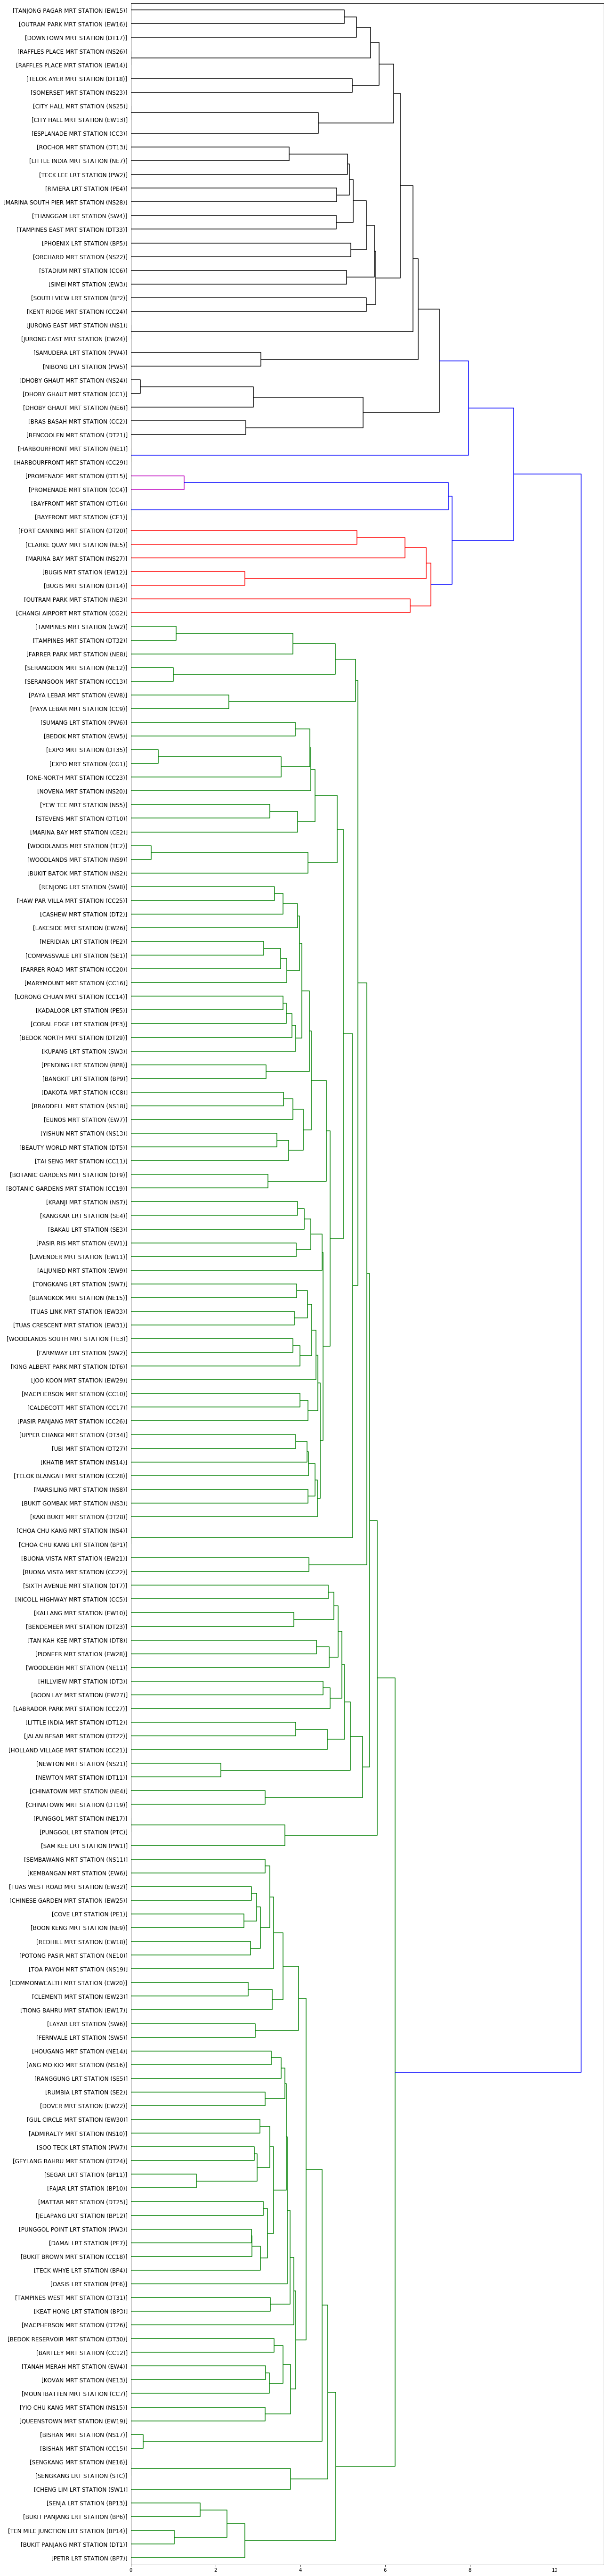

In [39]:
fig = pylab.figure(figsize=(18,100))
def llf(id):
    return '[%s]' % (sgp_onehot_grouped['Station ID'][id])
    
dendro = hierarchy.dendrogram(Z,  leaf_label_func=llf, leaf_rotation=0, leaf_font_size =12, orientation = 'right')

Forms flat clusters from the hierarchical clustering defined by the linkage matrix Z 

In [40]:
from scipy.cluster.hierarchy import fcluster

# Form no more than 5 flat clusters
hc_k = 5
hc_clusters = fcluster(Z, hc_k, criterion='maxclust')
hc_clusters

array([1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 1, 5,
       1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 5, 5, 2,
       1, 1, 1, 1, 1, 1, 1, 5, 5, 5, 1, 5, 5, 1, 1, 1, 1, 1, 1, 1, 1, 2,
       1, 1, 4, 4, 1, 1, 1, 1, 1, 1, 1, 5, 5, 1, 1, 1, 1, 1, 1, 5, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 5, 1, 1, 1, 1, 2, 5, 1, 1, 1, 1, 1, 1, 1,
       5, 1, 1, 1, 1, 5, 5, 2, 1, 1, 1, 1, 1, 1, 5, 1, 1, 3, 3, 1, 1, 1,
       1, 5, 5, 1, 1, 1, 5, 5, 1, 1, 5, 1, 1, 1, 1, 1, 1, 1, 5, 1, 5, 1,
       5, 5, 1, 1, 1, 5, 1, 1, 1, 1, 1, 5, 5, 1, 5, 1, 1, 5, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32)

Create a dataframe that links the HC's cluster label to each station

In [41]:
stations_venues_sorted_hc = stations_venues_sorted
stations_venues_sorted_hc['Cluster Label'] = hc_clusters
stations_venues_sorted_hc.head(20)

,Cluster Label,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,1,ADMIRALTY MRT STATION (NS10),Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,1,ALJUNIED MRT STATION (EW9),Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,1,ANG MO KIO MRT STATION (NS16),Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,1,BAKAU LRT STATION (SE3),Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,1,BANGKIT LRT STATION (BP9),Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
5,1,BARTLEY MRT STATION (CC12),Pet Store,Bus Station,Noodle House,Metro Station,Café
6,3,BAYFRONT MRT STATION (CE1),Hotel,Boutique,Bridge,Tea Room,Casino
7,3,BAYFRONT MRT STATION (DT16),Hotel,Boutique,Bridge,Tea Room,Casino
8,1,BEAUTY WORLD MRT STATION (DT5),Korean Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant
9,1,BEDOK MRT STATION (EW5),Chinese Restaurant,Coffee Shop,Japanese Restaurant,Food Court,Sandwich Place


In [42]:
# Form a dataframe that shows Station ID along with its latitude, longitudem cluster label and the 5 most common values
df_stnloc_venues_merged_hc = df_stnloc
df_stnloc_venues_merged_hc = df_stnloc_venues_merged_hc.join(stations_venues_sorted_hc.set_index('Station ID'), on='Station ID')
df_stnloc_venues_merged_hc['Cluster Label'] = hc_clusters
df_stnloc_venues_merged_hc.head(20)

,Station ID,Latitude,Longitude,Cluster Label,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADMIRALTY MRT STATION (NS10),1.440585,103.800998,1,Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,ALJUNIED MRT STATION (EW9),1.316433,103.882893,1,Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,ANG MO KIO MRT STATION (NS16),1.369933,103.849553,1,Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,BAKAU LRT STATION (SE3),1.388093,103.905418,1,Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,BANGKIT LRT STATION (BP9),1.380018,103.772667,1,Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
5,BARTLEY MRT STATION (CC12),1.342828,103.879746,1,Pet Store,Bus Station,Noodle House,Metro Station,Café
6,BAYFRONT MRT STATION (DT16),1.281874,103.859073,3,Hotel,Boutique,Bridge,Tea Room,Casino
7,BAYFRONT MRT STATION (CE1),1.281874,103.859073,3,Hotel,Boutique,Bridge,Tea Room,Casino
8,BEAUTY WORLD MRT STATION (DT5),1.341223,103.775810,1,Korean Restaurant,Café,Chinese Restaurant,Food Court,Asian Restaurant
9,BEDOK MRT STATION (EW5),1.323980,103.929959,1,Chinese Restaurant,Coffee Shop,Japanese Restaurant,Food Court,Sandwich Place


In [43]:
# create map
map_hc_clusters = folium.Map(location=[latitude, longitude], zoom_start=12)

# set color scheme for the clusters
x = np.arange(hc_k)
ys = [i + x + (i*x)**2 for i in range(hc_k)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(df_stnloc_venues_merged_hc['Latitude'], df_stnloc_venues_merged_hc['Longitude'], df_stnloc_venues_merged_hc['Station ID'], df_stnloc_venues_merged_hc['Cluster Label']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster+1), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_hc_clusters)
       
map_hc_clusters

### Examine clusters which are created using Hierachical Clustering 

Now, examine each cluster and determine the discriminating venue categories that distinguish each cluster.

#### Cluster 1

In [44]:
df_stnloc_venues_merged_hc.loc[df_stnloc_venues_merged_hc['Cluster Label'] == 1, df_stnloc_venues_merged_hc.columns[[0] + list(range(4, df_stnloc_venues_merged_hc.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
0,ADMIRALTY MRT STATION (NS10),Supermarket,Halal Restaurant,Food Court,Coffee Shop,Yoga Studio
1,ALJUNIED MRT STATION (EW9),Chinese Restaurant,Vegetarian / Vegan Restaurant,Café,Noodle House,Asian Restaurant
2,ANG MO KIO MRT STATION (NS16),Food Court,Coffee Shop,Dessert Shop,Snack Place,Supermarket
3,BAKAU LRT STATION (SE3),Trail,Food Stand,Food & Drink Shop,Fast Food Restaurant,Sandwich Place
4,BANGKIT LRT STATION (BP9),Food Court,Fruit & Vegetable Store,Bike Trail,Spa,Park
...,...,...,...,...,...,...
182,WOODLANDS SOUTH MRT STATION (TE3),Food Court,Park,Trail,Gym / Fitness Center,Video Store
183,WOODLEIGH MRT STATION (NE11),Café,Convenience Store,Chinese Restaurant,Soccer Field,Nightclub
184,YEW TEE MRT STATION (NS5),Fast Food Restaurant,Diner,Shopping Mall,Pool,Food Court
185,YIO CHU KANG MRT STATION (NS15),Food Court,Chinese Restaurant,Noodle House,Coffee Shop,Seafood Restaurant


#### Cluster 2

In [45]:
df_stnloc_venues_merged_hc.loc[df_stnloc_venues_merged_hc['Cluster Label'] == 2, df_stnloc_venues_merged_hc.columns[[0] + list(range(4, df_stnloc_venues_merged_hc.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
23,BUGIS MRT STATION (DT14),Bakery,Café,Hotel,Dessert Shop,Coffee Shop
24,BUGIS MRT STATION (EW12),Bakery,Dessert Shop,Hotel,Japanese Restaurant,Sushi Restaurant
34,CHANGI AIRPORT MRT STATION (CG2),Airport Lounge,Airport,Garden,Coffee Shop,Duty-free Shop
43,CLARKE QUAY MRT STATION (NE5),Hotel,Japanese Restaurant,Yoga Studio,Nightclub,Lounge
65,FORT CANNING MRT STATION (DT20),Japanese Restaurant,Hotel,Nightclub,Vegetarian / Vegan Restaurant,Bakery
101,MARINA BAY MRT STATION (CE2),Coffee Shop,Japanese Restaurant,Sandwich Place,Bar,Chinese Restaurant
117,OUTRAM PARK MRT STATION (EW16),Italian Restaurant,Japanese Restaurant,Café,Bakery,Burger Joint


#### Cluster 3

In [46]:
df_stnloc_venues_merged_hc.loc[df_stnloc_venues_merged_hc['Cluster Label'] == 3, df_stnloc_venues_merged_hc.columns[[0] + list(range(4, df_stnloc_venues_merged_hc.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
6,BAYFRONT MRT STATION (DT16),Hotel,Boutique,Bridge,Tea Room,Casino
7,BAYFRONT MRT STATION (CE1),Hotel,Boutique,Bridge,Tea Room,Casino
127,PROMENADE MRT STATION (DT15),Hotel,Hotel Bar,Japanese Restaurant,Buffet,Event Space
128,PROMENADE MRT STATION (CC4),Japanese Restaurant,Hotel,Hotel Bar,Buffet,Event Space


#### Cluster 4

In [47]:
df_stnloc_venues_merged_hc.loc[df_stnloc_venues_merged_hc['Cluster Label'] == 4, df_stnloc_venues_merged_hc.columns[[0] + list(range(4, df_stnloc_venues_merged_hc.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
68,HARBOURFRONT MRT STATION (NE1),Clothing Store,Chinese Restaurant,German Restaurant,Cosmetics Shop,Multiplex
69,HARBOURFRONT MRT STATION (CC29),Clothing Store,Chinese Restaurant,German Restaurant,Cosmetics Shop,Multiplex


#### Cluster 5

In [48]:
df_stnloc_venues_merged_hc.loc[df_stnloc_venues_merged_hc['Cluster Label'] == 5, df_stnloc_venues_merged_hc.columns[[0] + list(range(4, df_stnloc_venues_merged_hc.shape[1]))]]

,Station ID,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue
12,BENCOOLEN MRT STATION (DT21),Café,Hotel,Japanese Restaurant,Coffee Shop,Restaurant
21,BRAS BASAH MRT STATION (CC2),Hotel,Café,Chinese Restaurant,Restaurant,Ice Cream Shop
41,CITY HALL MRT STATION (EW13),Hotel,Café,Shopping Mall,French Restaurant,Cocktail Bar
42,CITY HALL MRT STATION (NS25),Hotel,Café,Shopping Mall,French Restaurant,Cocktail Bar
51,DHOBY GHAUT MRT STATION (NS24),Café,Hotel,Japanese Restaurant,Cosmetics Shop,Park
52,DHOBY GHAUT MRT STATION (NE6),Japanese Restaurant,Hotel,Café,Dessert Shop,Cosmetics Shop
53,DHOBY GHAUT MRT STATION (CC1),Café,Hotel,Japanese Restaurant,Dessert Shop,Cosmetics Shop
55,DOWNTOWN MRT STATION (DT17),Café,Hotel,Mexican Restaurant,Pub,Gym
56,ESPLANADE MRT STATION (CC3),Hotel,Concert Hall,Bar,Dumpling Restaurant,Shopping Mall
77,JURONG EAST MRT STATION (EW24),Coffee Shop,Chinese Restaurant,Japanese Restaurant,Bubble Tea Shop,Shopping Mall


## End of assignment project 